In [18]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [19]:
#DATASET USED
#https://www.kaggle.com/datasets/sanzidaakterarusha/scream-dataset?datasetId=1903423&sortBy=dateRun&tab=collaboration

# Se obtienen las diferentes rutas de los datos, tanto audios como metadata y path para obtener las muestras
file_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio'
screams_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sounds-screams/good'
explosions_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sounds-explosions/explosions'
urbansound8k = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/metadata/UrbanSound8K.csv')
file_viz = glob.glob('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold1/*')

In [20]:
#pd.set_option('display.max_rows', None)
urbansound8k.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [21]:
#Se organiza dataset para seleccionar la clase  de interes y las otras renombrarse como no interes
urbansound8k.loc[urbansound8k["class"] != "siren", "class"] = "non_event"

In [22]:
#Se cambian los valores de la columna classID para identificar unicamente las dos clases de interes
urbansound8k.loc[urbansound8k["classID"] != 8, "classID"] = 0  #non_event
urbansound8k.loc[urbansound8k["classID"] == 8, "classID"] = 2   #siren

In [23]:
urbansound8k.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        0   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        0   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        0   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        0   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        0   

       class  
0  non_event  
1  non_event  
2  non_event  
3  non_event  
4  non_event

In [24]:
#se cuenta el numero total de muestras de la clase de interes en SCREAMS
totalSamplesScream = 0
lastNameFilesScreams=[]
for file in os.listdir(screams_path):
    if file.endswith('.wav'):
        lastNameFilesScreams.append(file)
        totalSamplesScream+=1
print(totalSamplesScream)

391


In [25]:
#Se crea dataframe con los datos de los audios de sonidos de interes
dfScream = pd.DataFrame(lastNameFilesScreams, columns=['slice_file_name'])
dfScream['classID'] = 1 #Scream
dfScream['class'] = 'scream'
dfScream['fold'] = 12

totalSamplesScream = dfScream.count()[0]
totalSamplesScream

391

In [26]:
dfScream

slice_file_name  classID   class  fold
0      0_scream.wav        1  scream    12
1      1_scream.wav        1  scream    12
2      3_scream.wav        1  scream    12
3      2_scream.wav        1  scream    12
4      4_scream.wav        1  scream    12
..              ...      ...     ...   ...
386  387_scream.wav        1  scream    12
387  386_scream.wav        1  scream    12
388  388_scream.wav        1  scream    12
389  390_scream.wav        1  scream    12
390  389_scream.wav        1  scream    12

[391 rows x 4 columns]

In [27]:
#se cuenta el numero total de muestras de la clase de interes
totalSamplesSiren =  urbansound8k.loc[((urbansound8k["class"]=="siren"))].count()[0]
totalSamplesSiren

929

In [28]:
#se carga el numero total de muestras de la clase a agregar al dataset - explosions
totalSamplesExplosions = 0
lastNameFilesExplosions=[]
for file in os.listdir(explosions_path):
    if file.endswith('.wav'):
        lastNameFilesExplosions.append(file)
        totalSamplesExplosions+=1
print(totalSamplesExplosions)

209


In [29]:
#Se crea dataframe con los datos de los audios de sonidos de la clase a agregar - explosions
dfExplosion = pd.DataFrame(lastNameFilesExplosions, columns=['slice_file_name'])
dfExplosion['classID'] = 0 #non_event
dfExplosion['class'] = 'non_event'
dfExplosion['fold'] = 13

In [30]:
dfExplosion

slice_file_name  classID      class  fold
0    explosion_083.wav        0  non_event    13
1    explosion_084.wav        0  non_event    13
2    explosion_081.wav        0  non_event    13
3    explosion_080.wav        0  non_event    13
4    explosion_077.wav        0  non_event    13
..                 ...      ...        ...   ...
204  explosion_059.wav        0  non_event    13
205  explosion_010.wav        0  non_event    13
206  explosion_043.wav        0  non_event    13
207  explosion_019.wav        0  non_event    13
208  explosion_060.wav        0  non_event    13

[209 rows x 4 columns]

In [31]:
#Agregar en un dataset todos los sonidos de interes con la clase nueva agregada - explosions
print(urbansound8k.count()[0])
urbansound8k = urbansound8k.append(dfExplosion)
urbansound8k.count()[0]

8732


<ipython-input-31-fbef8c58e355>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  urbansound8k = urbansound8k.append(dfExplosion)


8941

In [32]:
#se toma una muestra aleatoria del tamaño de las muestras de la clase de interes para que quede balanceado
urbansound8k[urbansound8k['class'] == "non_event"].sample(n=totalSamplesScream).head()

slice_file_name      fsID       start         end  salience  fold  \
5051   196082-2-0-0.wav  196082.0    0.000000    3.315397       1.0     2   
5208   201652-5-5-1.wav  201652.0  259.309406  263.309406       1.0     2   
6589    49769-5-1-0.wav   49769.0   21.095675   22.539856       1.0     3   
4347   180937-7-2-9.wav  180937.0  256.663479  260.663479       1.0     1   
2965  162318-2-0-38.wav  162318.0   19.000000   23.000000       1.0     5   

      classID      class  
5051        0  non_event  
5208        0  non_event  
6589        0  non_event  
4347        0  non_event  
2965        0  non_event

In [33]:
#se toma una muestra aleatoria del tamaño de las muestras de la clase de interes para que quede balanceado en todas las clases
dfNonEvent = urbansound8k[urbansound8k['class'] == "non_event"].sample(n=totalSamplesScream)
dfScream = dfScream[dfScream['class'] == "scream"]
dfSiren = urbansound8k[urbansound8k['class'] == "siren"].sample(n=totalSamplesScream)

In [34]:
dfNonEvent

slice_file_name      fsID       start         end  salience  fold  \
7527   72259-1-7-11.wav   72259.0  148.781751  152.781751       2.0     5   
7237   65749-3-1-24.wav   65749.0   87.445545   91.445545       2.0     1   
66    explosion_201.wav       NaN         NaN         NaN       NaN    13   
4765  189982-0-0-39.wav  189982.0   19.500000   23.500000       1.0    10   
7132   62837-7-1-22.wav   62837.0  272.706708  276.706708       1.0     3   
...                 ...       ...         ...         ...       ...   ...   
7299    67049-3-0-0.wav   67049.0    0.074989    4.074989       1.0     7   
8669   99179-9-0-12.wav   99179.0    6.000000   10.000000       1.0     8   
5561  209992-5-3-22.wav  209992.0  420.108897  424.108897       1.0     7   
2847   161010-1-1-0.wav  161010.0  147.124081  148.444179       2.0     4   
501    107228-5-0-1.wav  107228.0    3.634753    7.634753       1.0     3   

      classID      class  
7527        0  non_event  
7237        0  non_event  
66          0  non_event  
4765        0  non_event  
7132        0  non_event  
...       ...        ...  
7299        0  non_event  
8669        0  non_event  
5561        0  non_event  
2847        0  non_event  
501         0  non_event  

[391 rows x 8 columns]

In [35]:
#se unen en un solo dataset las clases de interes con muestras balanceadas
dfComplete = dfNonEvent.append(dfSiren)
dfComplete = dfComplete.append(dfScream)
dfComplete.count()[0]

<ipython-input-35-a9829eaa3629>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfComplete = dfNonEvent.append(dfSiren)
<ipython-input-35-a9829eaa3629>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfComplete = dfComplete.append(dfScream)


1173

In [36]:
print(dfComplete[dfComplete['class'] == "siren"].count()[0])
print(dfComplete[dfComplete['classID'] == 2].count()[0])

391
391


In [37]:
print(dfComplete[dfComplete['class'] == "non_event"].count()[0])
print(dfComplete[dfComplete['classID'] == 0].count()[0])

391
391


In [38]:
print(dfComplete[dfComplete['class'] == "scream"].count()[0])
print(dfComplete[dfComplete['classID'] == 1].count()[0])

391
391


In [39]:
#Se cambia el dataset para unicamente tomar las clases de interés para el trabajo
dfComplete.head()

slice_file_name      fsID       start         end  salience  fold  \
7527   72259-1-7-11.wav   72259.0  148.781751  152.781751       2.0     5   
7237   65749-3-1-24.wav   65749.0   87.445545   91.445545       2.0     1   
66    explosion_201.wav       NaN         NaN         NaN       NaN    13   
4765  189982-0-0-39.wav  189982.0   19.500000   23.500000       1.0    10   
7132   62837-7-1-22.wav   62837.0  272.706708  276.706708       1.0     3   

      classID      class  
7527        0  non_event  
7237        0  non_event  
66          0  non_event  
4765        0  non_event  
7132        0  non_event

#Extracting features using Librosa

In [40]:
#Se define funcion para extrar las caracteristicas con la librería librosa, obetiendo los coeficientes ceptrales de frecuencia de Mel
#Se realiza un pading en el tamaño para que concuerden los tamaños de las caracteristicas de entrada al modelo.

def extract_features(file_name, Nmfcc, Nfft, NhopL, NwinL):

    samplerate = 22050
    longitudMaxAudio = 4
    max_pad_len = int(samplerate*longitudMaxAudio/NhopL) + int(samplerate*longitudMaxAudio/NhopL*0.05)  #Calculo longitud de salida de mfcc con 5% de tolerancia para longitud de audios

    try:
      audio, sample_rate = librosa.load(file_name, res_type='soxr_hq')
      mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=Nmfcc, n_fft=Nfft, hop_length=NhopL, win_length=NwinL)
      pad_width = max_pad_len - mfccs.shape[1]
      mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
      print("Error encountered while parsing file: ", file_name)
      return None
    #print(mfccs.shape)
    return mfccs

In [41]:
#Se realiza la extracción de caracteristicas, teniendo en cuenta la clase, si el sonido es de la carpeta agregada de la clase explosions va y busca este sonido en la carpeta requerida

def get_features(Nmfcc, Nfft, NhopL, NwinL):
  features = []
  # Iterate through each sound file and extract the features
  for index, row in dfComplete.iterrows():
      if((row["class"]=="non_event") & (row["fold"]==13)):
          file_name = os.path.join(os.path.abspath(explosions_path),str(row["slice_file_name"]))
          #file_name = ""
      elif(row["class"]=="scream"):
          file_name = os.path.join(os.path.abspath(screams_path),str(row["slice_file_name"]))
          #file_name = ""
      else:
          file_name = os.path.join(os.path.abspath(file_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
          #file_name = ""
      #print(file_name)
      class_label = row["classID"]
      data = extract_features(file_name, Nmfcc, Nfft, NhopL, NwinL)

      features.append([data, class_label])

  # Convert into a Panda dataframe
  featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
  return featuresdf

In [42]:
def splitFeaturesTrainTest(featuresdf, num_rows, num_columns, num_channels):
  X = np.array(featuresdf.feature.tolist())
  y = np.array(featuresdf.class_label.tolist())

  # Encode the classification labels
  le = LabelEncoder()
  yy = to_categorical(le.fit_transform(y))

  # split the dataset
  from sklearn.model_selection import train_test_split

  x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 3)

  x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
  x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
  num_labels = yy.shape[1]
  return x_train, x_test, y_train, y_test, num_labels

#Creating the Model

In [43]:
# Constructing model with RELu and SoftMax activation functions:
def getModel(num_rows, num_columns, num_channels, num_labels, k_size):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=k_size, input_shape=(num_rows, num_columns, num_channels), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=k_size, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=k_size, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=k_size, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(num_labels, activation='softmax'))
    return model

#TRANSFER LEARNING AND FINE TUNING

In [60]:
modelCheckpoint_path = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream_siren/scream_siren_check'
modelSaved_path_Complete = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/complete/saved_complete_4'
modelSave_path_scream_siren = '/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/Fusion/TL_Complete/scream_siren/saved_scream_siren_TL_4'



#1	3	4096	4096	4096	0	2
#2	12	4096	4096	4096	0	3
#3	27	4096	4096	4096	0	3
#4	45	4096	4096	4096	0	5

samplerate = 22050
longitudMaxAudio = 4
Nmfcc = 45
Nfft = 4096
NwinL = 4096
iterableNhopL = 1.0
NhopL =  4096       #int(iterableNhopL*NwinL)
k_size = 5
num_rows = Nmfcc
num_columns = int(samplerate*longitudMaxAudio/NhopL) + int(samplerate*longitudMaxAudio/NhopL*0.05)  #Calculo longitud de salida de mfcc con 5% de tolerancia para longitud de audios
num_channels = 1

featuresdf = get_features(Nmfcc, Nfft, NhopL, NwinL)
x_train, x_test, y_train, y_test, num_labels = splitFeaturesTrainTest(featuresdf, num_rows, num_columns, num_channels)


#Load trained model
modelTrained = tf.keras.models.load_model(modelSaved_path_Complete)

model = getModel(num_rows, num_columns, num_channels, num_labels, k_size)

# Transferir los pesos del modelo original al nuevo modelo
for layer, original_layer in zip(model.layers[:-1], modelTrained.layers):
    layer.set_weights(original_layer.get_weights())

#Compile model with categorical crossentropy loss function
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

#Train Model
num_epochs = 50
num_batch_size = 256

earlystopper = EarlyStopping(patience=10, verbose=0)
checkpointer = ModelCheckpoint(filepath= modelCheckpoint_path, verbose=0, save_best_only=True)

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data = (x_test, y_test), callbacks=[earlystopper, checkpointer], verbose=0)

model.save(modelSave_path_scream_siren)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=4096 is too large for input signal of length=2205
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=4096 is too large for input signal of length=3969
  warnings.warn(


In [61]:
# Evaluating the model on the training and testing set

score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  1.0
Testing Accuracy:  0.9702127575874329


In [62]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 45, 22, 16)        416       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 23, 11, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 23, 11, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 23, 11, 32)        12832     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 12, 6, 32)         0         
 ng2D)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 12, 6, 32)        

#Evaluation Metrics

In [64]:
y_true = np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(x_test),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(y_true,y_pred))
print('\n\nClassification Report : \n\n',classification_report(y_true,y_pred))

8/8 [==============================] - 0s 20ms/step

Confusion Matrix :


[[80  1  2]
 [ 0 79  0]
 [ 3  1 69]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.96      0.96      0.96        83
           1       0.98      1.00      0.99        79
           2       0.97      0.95      0.96        73

    accuracy                           0.97       235
   macro avg       0.97      0.97      0.97       235
weighted avg       0.97      0.97      0.97       235



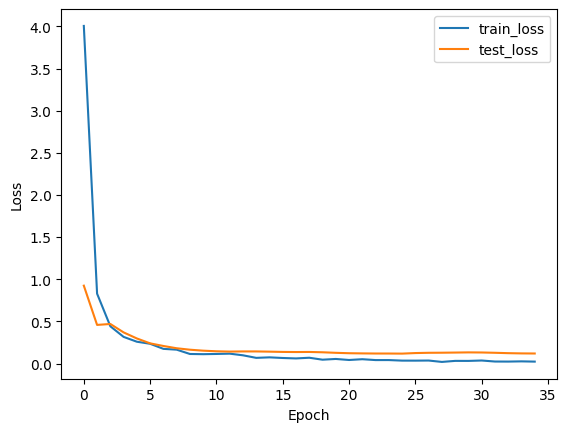

In [65]:
# Plotting Loss of Model

metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

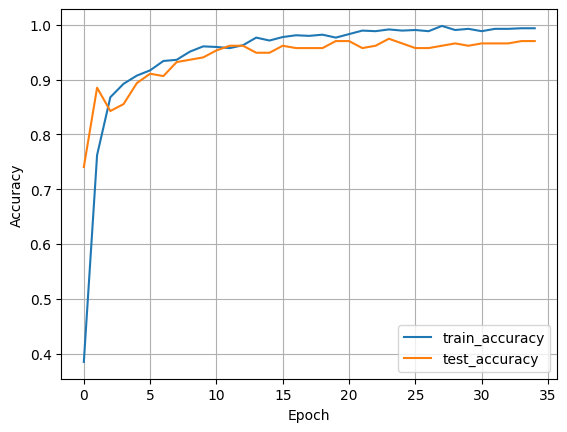

In [66]:
# Plotting Accuracy of Model

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#Save the entire model as a SavedModel.

In [ ]:
#!mkdir -p saved_model

model.save('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/scream/saved_scream')

#Reload a fresh Keras model from the saved model

In [ ]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from sklearn import metrics
import librosa as lb
import IPython.display as ipd
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
def predict(path):
    num_rows = 40
    num_columns = 174
    num_channels = 1
    audio = extract_features(path)
    audioP = audio.reshape(1, num_rows, num_columns, num_channels)
    probOut = model.predict(audioP)[0]
    indexMax = np.argmax(probOut)
    print(probOut)
    print(indexMax)
    maxProb = probOut[indexMax]
    if(maxProb>0.70):
      if(indexMax==0):
        classP = 'scream'
      else:
        classP = 'non_scream'
    else:
      classP = 'None'
    print('Class predicted :',classP,'\n\n')
    return ipd.Audio(path)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/scream/saved_scream')

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 42, 32)         0

In [ ]:
predict('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/UrbanSounds8k/UrbanSound8K/audio/fold7/102853-8-0-1.wav')


1/1 [==============================] - 0s 124ms/step
[0.11822042 0.88177955]
1
Class predicted : non_scream 




In [ ]:
predict('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sounds-screams/good/38_scream.wav')

1/1 [==============================] - 0s 40ms/step
[0.752234   0.24776606]
0
Class predicted : scream 




#To record and save audio directly on colab

In [ ]:
#Se implementan funciones para grabar y guardar audio directamente desde el colab
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1200))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def recordAndSave(sec=3, path="audio.wav"):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1200))
  b = b64decode(s.split(',')[1])
  with open(path,'wb') as f:
    f.write(b)
  return path  # or webm ?

In [ ]:
#Grabar porción de audio directamente desde el colab
pathaudio2 = recordAndSave(sec=3,path='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sonidosPrueba/prueba1.wav')

<IPython.core.display.Javascript object>

In [ ]:
#Se predice el audio que fue grabado anteriormente
predict(pathaudio2)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[0.9985104  0.00148962]
0
Class predicted : gun_shot 




In [ ]:
#Grabar porción de audio directamente desde el colab
pathaudio3 = recordAndSave(sec=3,path='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/sonidosPrueba/prueba2.wav')

<IPython.core.display.Javascript object>

In [ ]:
#Se predice el audio que fue grabado anteriormente
predict(pathaudio3)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[3.7462482e-07 9.9999964e-01]
1
Class predicted : siren 




#CONVERT TO TF LITE MODEL

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/scream/saved_scream') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/scream/scream_lite.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path ='/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/scream/scream_lite.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1  40 174   1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>
